# Final Project
## Machine Learning: Prediction on bike sharing demand

- Check where the file locate

In [1]:
pwd

'/Users/hchae/Desktop'

In [2]:
# Import

import folium
from folium.plugins import MarkerCluster

import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

### Importing the Dataset

In [3]:
#dataset = pd.read_csv('04JourneyDataExtract01Apr2016-30Apr2016.csv')

dataset = pd.read_csv(
    '04JourneyDataExtract01Apr2016-30Apr2016.csv',
    #sep ='\t',
    #header = None,
    parse_dates = ['Start Date'],
    infer_datetime_format = True,
    dayfirst = True
    
    #index_col = "Start Date"
)

In [4]:
# Convert EndStation Id from float to int
dataset = dataset.fillna(0)
dataset['EndStation Id'] = dataset['EndStation Id'].astype(int)

dataset.dtypes

Rental Id                     int64
Duration                    float64
Bike Id                       int64
End Date                     object
EndStation Id                 int64
EndStation Name              object
Start Date           datetime64[ns]
StartStation Id               int64
StartStation Name            object
dtype: object

In [5]:
dataset

,Rental Id,Duration,Bike Id,End Date,EndStation Id,EndStation Name,Start Date,StartStation Id,StartStation Name
0,52538879,660.0,395,01/04/2016 00:11,137,"Bourne Street, Belgravia",2016-04-01 00:00:00,573,"Limerston Street, West Chelsea"
1,52538876,420.0,12931,01/04/2016 00:07,507,"Clarkson Street, Bethnal Green",2016-04-01 00:00:00,399,"Brick Lane Market, Shoreditch"
2,52538877,420.0,7120,01/04/2016 00:07,507,"Clarkson Street, Bethnal Green",2016-04-01 00:00:00,399,"Brick Lane Market, Shoreditch"
3,52538878,300.0,1198,01/04/2016 00:05,616,"Aintree Street, Fulham",2016-04-01 00:00:00,599,"Manbre Road, Hammersmith"
4,52538874,1260.0,10739,01/04/2016 00:21,486,"Granby Street, Shoreditch",2016-04-01 00:00:00,135,"Clerkenwell Green, Clerkenwell"
...,...,...,...,...,...,...,...,...,...
781704,53351707,300.0,13793,01/05/2016 00:04,654,"Ashmole Estate, Oval",2016-04-30 23:59:00,86,"Sancroft Street, Vauxhall"
781705,53351714,1500.0,5566,01/05/2016 00:24,47,"Warwick Avenue Station, Maida Vale",2016-04-30 23:59:00,260,"Broadwick Street, Soho"
781706,53351709,7020.0,10161,01/05/2016 01:56,156,"New Kent Road, The Borough",2016-04-30 23:59:00,156,"New Kent Road, The Borough"
781707,53351708,7020.0,2759,01/05/2016 01:56,156,"New Kent Road, The Borough",2016-04-30 23:59:00,156,"New Kent Road, The Borough"


## Extract required information from dataset
### To predict number of bikes in each station in near future
- Number of arrival bike
- Number of depature bike



In [6]:
# Extract the daily data by the date in the dataset.

newDataset = (pd.to_datetime(dataset['End Date'], dayfirst = True)
        .dt.floor('d')
        .reset_index(name = 'timestamp'))
        #.rename_axis('Date')
        #.value_counts()
        #.reset_index(name='count')
        

newDataset['EndStation Id'] = dataset['EndStation Id'].values
newDataset['StartStation Id'] = dataset['StartStation Id'].values

#newDataset = pd.date_range(start='2016-04-01', end='2016-04-30')
#newDataset['Date'] = pd.to_datetime(newDataset['Date'], errors='coerce')
#newDataset['Date'] = newDataset['Date'].dt.strftime('%d-%m-%Y')

In [7]:
#dataset['Start Date'] = dataset['Start Date'].dt.strftime('%y-%m-%d')
#newDataset['Date'] = pd.to_datetime(newDataset['Date'], errors='coerce')
#newDataset['Date'] = newDataset['Date'].dt.strftime('%d-%m-%Y')

newDataset

,index,timestamp,EndStation Id,StartStation Id
0,0,2016-04-01,137,573
1,1,2016-04-01,507,399
2,2,2016-04-01,507,399
3,3,2016-04-01,616,599
4,4,2016-04-01,486,135
...,...,...,...,...
781704,781704,2016-05-01,654,86
781705,781705,2016-05-01,47,260
781706,781706,2016-05-01,156,156
781707,781707,2016-05-01,156,156


In [8]:
# Considering the missing values 
# Exclude the whole row if only one of the variables was empty.

newDataset = newDataset[dataset['EndStation Name'].str.len() > 0]
newDataset

,index,timestamp,EndStation Id,StartStation Id
0,0,2016-04-01,137,573
1,1,2016-04-01,507,399
2,2,2016-04-01,507,399
3,3,2016-04-01,616,599
4,4,2016-04-01,486,135
...,...,...,...,...
781704,781704,2016-05-01,654,86
781705,781705,2016-05-01,47,260
781706,781706,2016-05-01,156,156
781707,781707,2016-05-01,156,156


In [9]:
# Extract number of bikes arriving to the station
In = newDataset.groupby(['timestamp','EndStation Id'])['EndStation Id'].count().reset_index(name ='In')
In

,timestamp,EndStation Id,In
0,2016-04-01,1,17
1,2016-04-01,2,42
2,2016-04-01,3,51
3,2016-04-01,4,44
4,2016-04-01,5,48
...,...,...,...
22758,2016-05-08,406,1
22759,2016-05-08,516,1
22760,2016-05-09,111,1
22761,2016-05-09,302,1


In [10]:
# Extract number of bikes leaving to the station
Out = newDataset.groupby(['timestamp','StartStation Id'])['StartStation Id'].count().reset_index(name ='Out')

Out

,timestamp,StartStation Id,Out
0,2016-04-01,1,22
1,2016-04-01,2,31
2,2016-04-01,3,39
3,2016-04-01,4,37
4,2016-04-01,5,38
...,...,...,...
22735,2016-05-08,307,1
22736,2016-05-08,553,1
22737,2016-05-09,503,1
22738,2016-05-09,693,1


In [11]:
# combine dataframe : In and Out 

InOut = In[['timestamp', 'In']].copy()
InOut['Out'] = Out[['Out']].copy()
InOut['Station Id'] =  Out[['StartStation Id']].copy()
InOut['Total'] = In['In'] - Out['Out']

InOut = InOut.fillna(0)
InOut['Out'] = InOut['Out'].astype(int)
InOut['Station Id'] = InOut['Station Id'].astype(int)

InOut

,timestamp,In,Out,Station Id,Total
0,2016-04-01,17,22,1,-5.0
1,2016-04-01,42,31,2,11.0
2,2016-04-01,51,39,3,12.0
3,2016-04-01,44,37,4,7.0
4,2016-04-01,48,38,5,10.0
...,...,...,...,...,...
22758,2016-05-08,1,0,0,0.0
22759,2016-05-08,1,0,0,0.0
22760,2016-05-09,1,0,0,0.0
22761,2016-05-09,1,0,0,0.0


In [12]:
InOut.dtypes

timestamp     datetime64[ns]
In                     int64
Out                    int64
Station Id             int64
Total                float64
dtype: object

In [13]:
#condition_df = pd.read_csv("london_merged.csv")

condition_df = pd.read_csv(
  "london_merged.csv", 
  parse_dates = ['timestamp'], 
  index_col = "timestamp"
)

In [14]:
condition_df['date'] = condition_df.index.day
condition_df['month'] = condition_df.index.month
condition_df['year'] = condition_df.index.year

date = condition_df['date'].values
month = condition_df['month'].values
year = condition_df['year'].values

In [15]:
condition_df

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,date,month,year
timestamp,,,,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0,4,1,2015
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0,4,1,2015
2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0,4,1,2015
2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0,4,1,2015
2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0,4,1,2015
...,...,...,...,...,...,...,...,...,...,...,...,...
2017-01-03 19:00:00,1042,5.0,1.0,81.0,19.0,3.0,0.0,0.0,3.0,3,1,2017
2017-01-03 20:00:00,541,5.0,1.0,81.0,21.0,4.0,0.0,0.0,3.0,3,1,2017
2017-01-03 21:00:00,337,5.5,1.5,78.5,24.0,4.0,0.0,0.0,3.0,3,1,2017


In [16]:
df_by_day = condition_df.resample('D').sum()
df_by_day

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,date,month,year
timestamp,,,,,,,,,,,,
2015-01-04,9234,59.5,15.5,2262.5,180.0,69.0,0.0,24.0,72.0,96,24,48360
2015-01-05,20372,193.0,161.0,1927.5,212.5,80.0,0.0,0.0,72.0,120,24,48360
2015-01-06,20613,188.5,128.0,1893.5,384.0,74.0,0.0,0.0,72.0,144,24,48360
2015-01-07,21064,171.5,103.5,1796.5,454.5,60.0,0.0,0.0,69.0,161,23,46345
2015-01-08,15601,234.0,187.0,1903.5,491.5,84.0,0.0,0.0,72.0,192,24,48360
...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-30,11566,78.5,25.5,2368.5,216.0,105.0,0.0,0.0,72.0,720,288,48384
2016-12-31,11424,178.5,121.0,2183.0,319.5,98.0,0.0,24.0,72.0,744,288,48384
2017-01-01,6421,168.0,106.5,2122.5,339.0,150.0,0.0,24.0,72.0,24,24,48408


In [17]:
# To calculate the average values for conditions

num_hours = 24


average_df = df_by_day[['is_holiday', 'is_weekend']].copy()
average_df['avg_temp'] = df_by_day['t1']/num_hours
average_df['avg_temp_feel'] = df_by_day['t2']/num_hours
average_df['avg_humidity'] = df_by_day['hum']/num_hours
average_df['avg_windSpeed'] = df_by_day['wind_speed']/num_hours
average_df['date'] = condition_df['date']

In [18]:
average_df

,is_holiday,is_weekend,avg_temp,avg_temp_feel,avg_humidity,avg_windSpeed,date
timestamp,,,,,,,
2015-01-04,0.0,24.0,2.479167,0.645833,94.270833,7.500000,4.0
2015-01-05,0.0,0.0,8.041667,6.708333,80.312500,8.854167,5.0
2015-01-06,0.0,0.0,7.854167,5.333333,78.895833,16.000000,6.0
2015-01-07,0.0,0.0,7.145833,4.312500,74.854167,18.937500,7.0
2015-01-08,0.0,0.0,9.750000,7.791667,79.312500,20.479167,8.0
...,...,...,...,...,...,...,...
2016-12-30,0.0,0.0,3.270833,1.062500,98.687500,9.000000,30.0
2016-12-31,0.0,24.0,7.437500,5.041667,90.958333,13.312500,31.0
2017-01-01,0.0,24.0,7.000000,4.437500,88.437500,14.125000,1.0


In [19]:
merged_df = pd.merge(InOut.reset_index(), average_df.reset_index(), how='inner', on=['timestamp'])

merged_df

,index,timestamp,In,Out,Station Id,Total,is_holiday,is_weekend,avg_temp,avg_temp_feel,avg_humidity,avg_windSpeed,date
0,0,2016-04-01,17,22,1,-5.0,0.0,0.0,8.520833,7.895833,66.500000,11.166667,1.0
1,1,2016-04-01,42,31,2,11.0,0.0,0.0,8.520833,7.895833,66.500000,11.166667,1.0
2,2,2016-04-01,51,39,3,12.0,0.0,0.0,8.520833,7.895833,66.500000,11.166667,1.0
3,3,2016-04-01,44,37,4,7.0,0.0,0.0,8.520833,7.895833,66.500000,11.166667,1.0
4,4,2016-04-01,48,38,5,10.0,0.0,0.0,8.520833,7.895833,66.500000,11.166667,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
22758,22758,2016-05-08,1,0,0,0.0,0.0,24.0,19.250000,19.229167,57.145833,15.562500,8.0
22759,22759,2016-05-08,1,0,0,0.0,0.0,24.0,19.250000,19.229167,57.145833,15.562500,8.0
22760,22760,2016-05-09,1,0,0,0.0,0.0,0.0,17.708333,17.645833,65.729167,16.145833,9.0
22761,22761,2016-05-09,1,0,0,0.0,0.0,0.0,17.708333,17.645833,65.729167,16.145833,9.0


In [20]:
merged_df.dtypes

index                     int64
timestamp        datetime64[ns]
In                        int64
Out                       int64
Station Id                int64
Total                   float64
is_holiday              float64
is_weekend              float64
avg_temp                float64
avg_temp_feel           float64
avg_humidity            float64
avg_windSpeed           float64
date                    float64
dtype: object

### Looking for outliers

/Users/hchae/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Total', ylabel='Density'>

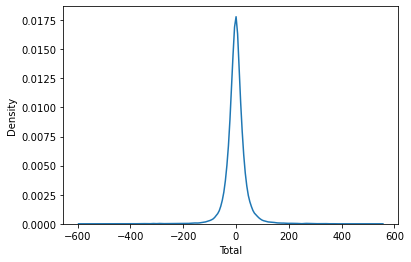

In [21]:
import seaborn as sns
fig, ax = plt.subplots(1, 1, figsize = (6, 4))
sns.distplot(merged_df['Total'], hist = False, ax = ax)

### Add Longitude and Latitude for the station location

In [22]:
location = pd.read_csv("Cycle hire docking stations.csv")

In [23]:
merged_df['longitude'] = 0
merged_df['latitude'] = 0

In [24]:
cnt = 0
loc_cnt = 0

for cnt in range(0, len(merged_df['Station Id'])):
    data = merged_df['Station Id'][cnt]
    for loc_cnt in range(0,len(location['Station.Id'])):
        loc = location['Station.Id'][loc_cnt]
        if (data - loc) == 0:
            merged_df['longitude'][cnt] = location['longitude'][loc_cnt]
            merged_df['latitude'][cnt] = location['latitude'][loc_cnt]   
    loc_cnt = -1
    
cnt += 1
loc_cnt += 1

<ipython-input-24-f2fe463035ea>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['longitude'][cnt] = location['longitude'][loc_cnt]
<ipython-input-24-f2fe463035ea>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['latitude'][cnt] = location['latitude'][loc_cnt]


In [25]:
merged_df

,index,timestamp,In,Out,Station Id,Total,is_holiday,is_weekend,avg_temp,avg_temp_feel,avg_humidity,avg_windSpeed,date,longitude,latitude
0,0,2016-04-01,17,22,1,-5.0,0.0,0.0,8.520833,7.895833,66.500000,11.166667,1.0,-0.109971,51.5292
1,1,2016-04-01,42,31,2,11.0,0.0,0.0,8.520833,7.895833,66.500000,11.166667,1.0,-0.197574,51.4996
2,2,2016-04-01,51,39,3,12.0,0.0,0.0,8.520833,7.895833,66.500000,11.166667,1.0,-0.084606,51.5213
3,3,2016-04-01,44,37,4,7.0,0.0,0.0,8.520833,7.895833,66.500000,11.166667,1.0,-0.120974,51.5301
4,4,2016-04-01,48,38,5,10.0,0.0,0.0,8.520833,7.895833,66.500000,11.166667,1.0,-0.156876,51.4931
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22758,22758,2016-05-08,1,0,0,0.0,0.0,24.0,19.250000,19.229167,57.145833,15.562500,8.0,0.000000,0.0000
22759,22759,2016-05-08,1,0,0,0.0,0.0,24.0,19.250000,19.229167,57.145833,15.562500,8.0,0.000000,0.0000
22760,22760,2016-05-09,1,0,0,0.0,0.0,0.0,17.708333,17.645833,65.729167,16.145833,9.0,0.000000,0.0000
22761,22761,2016-05-09,1,0,0,0.0,0.0,0.0,17.708333,17.645833,65.729167,16.145833,9.0,0.000000,0.0000


In [26]:
#merged_df.to_csv (r'C:Desktop\export_Joint_dataframe.csv', index = False, header=True)

AttributeError: 'AxesSubplot' object has no attribute 'fig'

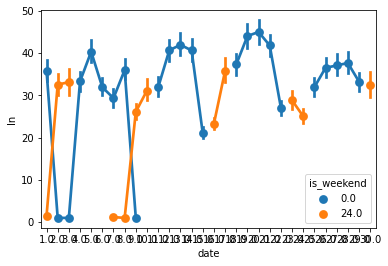

In [27]:
ax = sns.pointplot(x = "date", y = "In", data = merged_df, hue = "is_weekend");
ax.set(xlabel = 'date', ylabel = 'In')
ax.fig.set_figwidth(8.27)
ax.fig.set_figheight(11.7)

[Text(0.5, 0, 'date'), Text(0, 0.5, 'Total')]

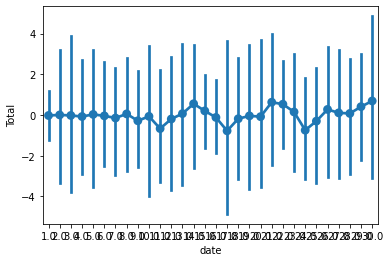

In [28]:
ax = sns.pointplot(x = "date", y = "Total", data = merged_df);
ax.set(xlabel = 'date', ylabel = 'Total')
#ax.fig.set_figwidth(8.27)
#ax.fig.set_figheight(11.7)

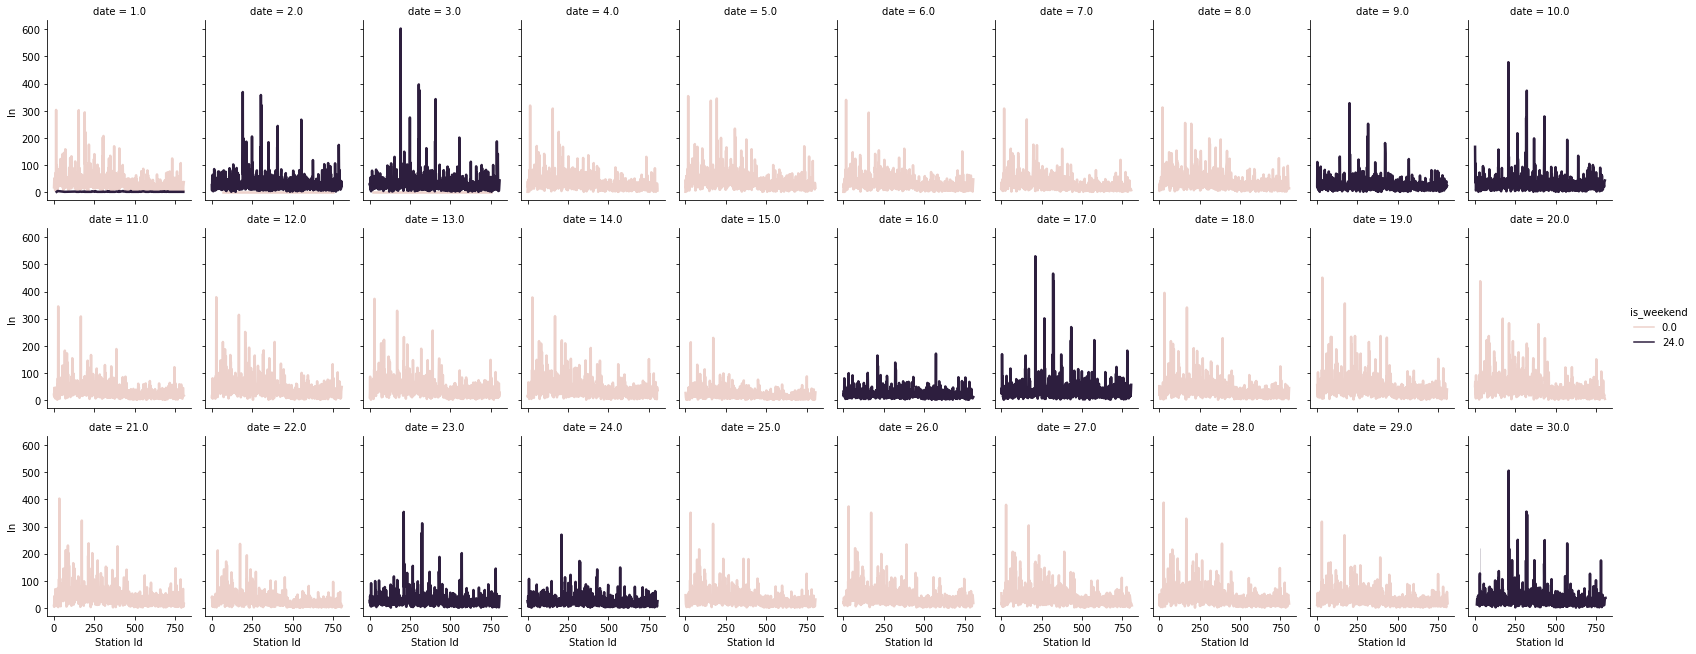

In [29]:
sns.relplot(x = "Station Id", y = "In", hue = "is_weekend",
            col = "date", col_wrap = 10,
            height = 3, aspect = .75, linewidth = 2.5,
            kind = "line", data = merged_df);

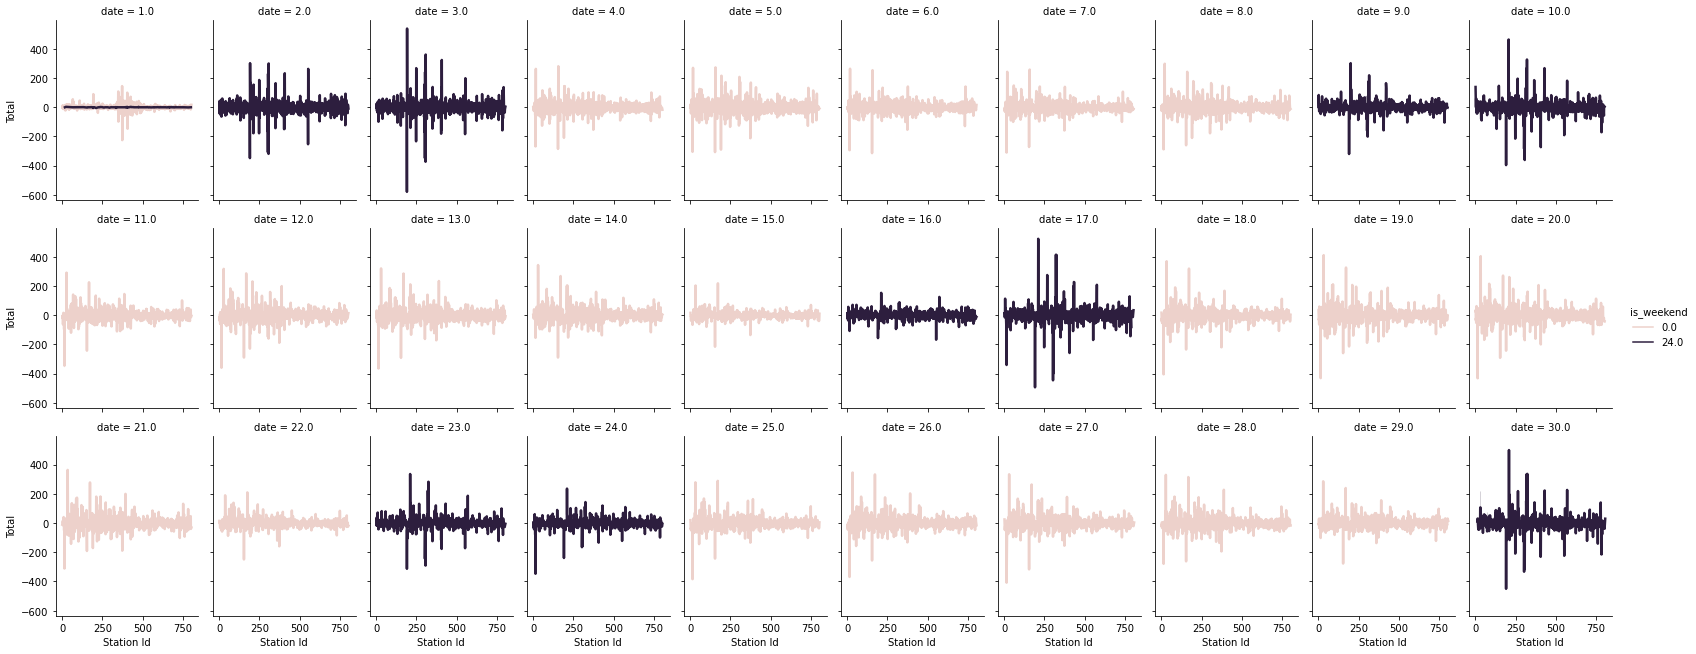

In [35]:
sns.relplot(x = "Station Id", y = "Total", hue = "is_weekend",
            col = "date", col_wrap = 10,
            height = 3, aspect = .75, linewidth = 2.5,
            kind = "line", data = merged_df);

# Machine Learning

## Linear Regression

In [30]:
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
%matplotlib inline

- We want to predict the Total count depending upon the Timestamp recorded. Therefore our attribute set will consist of the “Total” column which is stored in the X variable, and the label will be the “timestamp” column which is stored in y variable.

In [31]:
X = merged_df['Station Id'].values.reshape(-1,1) # reshape to make it two-dimentional
y = merged_df['Total'].values # Predict

- Split data into train and test
- 80% for training and 20% for testing

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [88]:
# X_train = X_test (num of columns)

print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (18210, 1)
Training Labels Shape: (18210,)
Testing Features Shape: (4553, 1)
Testing Labels Shape: (4553,)


- Training the algorithm

In [89]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [90]:
#To retrieve the intercept:
print(model.intercept_)

#For retrieving the slope:
print(model.coef_)

33.32547001115625
[0.03851146]


In [91]:
y_pred = model.predict(X_test)

In [92]:
linear_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
linear_df

,Actual,Predicted
0,9,33.595050
1,8,34.134211
2,95,33.595050
3,36,34.018676
4,41,34.249745
...,...,...
4548,3,34.288256
4549,22,34.134211
4550,14,33.441004
4551,32,34.057188


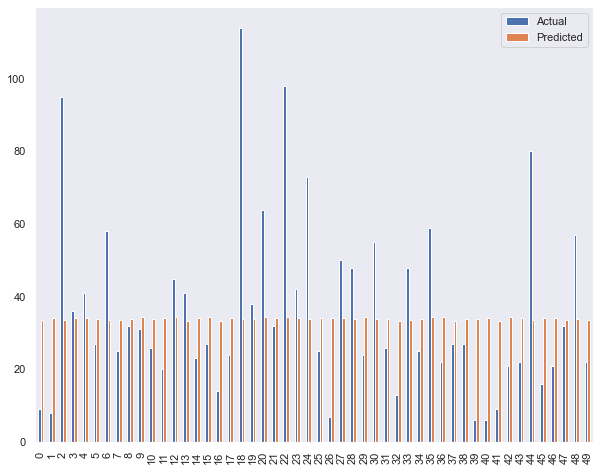

In [93]:
graph = linear_df.head(50) # Only taking frist 50 record
graph.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

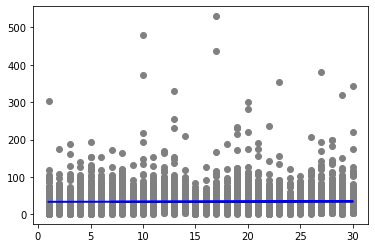

In [64]:
plt.scatter(X_test, y_test,  color='gray')
plt.plot(X_test, y_pred, color='blue', linewidth=2)
plt.show()

In [72]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
#print('Accuracy:', metrics.accuracy_score(y_test,y_pred))

# Calculate mean absolute percentage error (MAPE)
errors = abs(y_pred - y_test)
MAPE = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(MAPE)
print('Accuracy:', round(accuracy, 2), '%.')
    

Mean Absolute Error: 20.535259772773443
Mean Squared Error: 1110.5341994256776
Root Mean Squared Error: 33.32467853446868
Accuracy: -53.16 %.


- You can see that the value of root mean squared error is 43.61, which is more than ****10%**** of the mean value of the percentages of all the temperature i.e. 22.41. This means that our algorithm was not very accurate and can not make reasonable or good predictions.

## LSTM (Long short-term memory neural networks)

In [32]:
train_size = int(len(merged_df) * 0.8)
test_size = len(merged_df) - train_size
train, test = merged_df.iloc[0:train_size], merged_df.iloc[train_size:len(merged_df)]
print(len(train),len(test))

18210 4553


In [34]:
from sklearn.preprocessing import RobustScaler

f_transformer = RobustScaler()
feature_columns = ['avg_temp', 'avg_temp_feel', 'avg_humidity', 'avg_windSpeed']
f_transformer = f_transformer.fit(train[feature_columns].to_numpy())
train.loc[:, feature_columns] = f_transformer.transform(train[feature_columns].to_numpy())

<ipython-input-34-3de8495c2a4b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.loc[:, feature_columns] = f_transformer.transform(train[feature_columns].to_numpy())


In [35]:
train.head()

,index,timestamp,In,Out,Station Id,Total,is_holiday,is_weekend,avg_temp,avg_temp_feel,avg_humidity,avg_windSpeed,date,longitude,latitude
0,0,2016-04-01,17,22,1,-5.0,0.0,0.0,-0.333333,-0.111675,-0.07,-0.526946,1.0,-0.109971,51.5292
1,1,2016-04-01,42,31,2,11.0,0.0,0.0,-0.333333,-0.111675,-0.07,-0.526946,1.0,-0.197574,51.4996
2,2,2016-04-01,51,39,3,12.0,0.0,0.0,-0.333333,-0.111675,-0.07,-0.526946,1.0,-0.084606,51.5213
3,3,2016-04-01,44,37,4,7.0,0.0,0.0,-0.333333,-0.111675,-0.07,-0.526946,1.0,-0.120974,51.5301
4,4,2016-04-01,48,38,5,10.0,0.0,0.0,-0.333333,-0.111675,-0.07,-0.526946,1.0,-0.156876,51.4931


In [36]:
Total_transformer = RobustScaler()
Total_transformer = Total_transformer.fit(train[['Total']])
train['Total'] = Total_transformer.transform(train[['Total']])

<ipython-input-36-9078b859fbc1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Total'] = Total_transformer.transform(train[['Total']])


In [37]:
train.head()

,index,timestamp,In,Out,Station Id,Total,is_holiday,is_weekend,avg_temp,avg_temp_feel,avg_humidity,avg_windSpeed,date,longitude,latitude
0,0,2016-04-01,17,22,1,-0.161290,0.0,0.0,-0.333333,-0.111675,-0.07,-0.526946,1.0,-0.109971,51.5292
1,1,2016-04-01,42,31,2,0.354839,0.0,0.0,-0.333333,-0.111675,-0.07,-0.526946,1.0,-0.197574,51.4996
2,2,2016-04-01,51,39,3,0.387097,0.0,0.0,-0.333333,-0.111675,-0.07,-0.526946,1.0,-0.084606,51.5213
3,3,2016-04-01,44,37,4,0.225806,0.0,0.0,-0.333333,-0.111675,-0.07,-0.526946,1.0,-0.120974,51.5301
4,4,2016-04-01,48,38,5,0.322581,0.0,0.0,-0.333333,-0.111675,-0.07,-0.526946,1.0,-0.156876,51.4931


In [38]:
test.loc[:, feature_columns] = f_transformer.transform(test[feature_columns].to_numpy())
test.head()

<ipython-input-38-a3aef1a352b9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, feature_columns] = f_transformer.transform(test[feature_columns].to_numpy())


,index,timestamp,In,Out,Station Id,Total,is_holiday,is_weekend,avg_temp,avg_temp_feel,avg_humidity,avg_windSpeed,date,longitude,latitude
18210,18210,2016-04-25,22,21,169,1.0,0.0,0.0,8.041667,5.729167,74.208333,18.270833,25.0,-0.165164,51.5147
18211,18211,2016-04-25,56,33,170,23.0,0.0,0.0,8.041667,5.729167,74.208333,18.270833,25.0,-0.108068,51.5278
18212,18212,2016-04-25,310,21,171,289.0,0.0,0.0,8.041667,5.729167,74.208333,18.270833,25.0,-0.186754,51.4916
18213,18213,2016-04-25,27,19,172,8.0,0.0,0.0,8.041667,5.729167,74.208333,18.270833,25.0,-0.173716,51.4912
18214,18214,2016-04-25,32,44,173,-12.0,0.0,0.0,8.041667,5.729167,74.208333,18.270833,25.0,-0.113001,51.5049


In [39]:
test['Total'] = Total_transformer.transform(test[['Total']])
test['Total'].head()

<ipython-input-39-808472d4a517>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Total'] = Total_transformer.transform(test[['Total']])


18210    0.032258
18211    0.741935
18212    9.322581
18213    0.258065
18214   -0.387097
Name: Total, dtype: float64

In [40]:
## Create X_train, y_train, X_test and y_test

def createDataset(X, y, time_steps):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        data = X.iloc[i:(i + time_steps)].values
        Xs.append(data)        
        ys.append(y.iloc[i + time_steps])
        
    return np.array(Xs), np.array(ys)

time_steps = 10
X_train, y_train = createDataset(train, train.Total, time_steps)
X_test, y_test = createDataset(test, test.Total, time_steps)
print(X_train.shape, y_train.shape)

(18200, 10, 15) (18200,)


In [41]:
# Predicting Demand 

from tensorflow.keras import layers

model = keras.Sequential()
model.add(
  layers.Bidirectional(
    layers.LSTM(
      units = 128, 
      input_shape = (X_train.shape[1], X_train.shape[2])
    )
  )
)
model.add(layers.Dropout(rate = 0.2))
model.add(layers.Dense(units = 1))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')
model

ModuleNotFoundError: No module named 'tensorflow'